# Convolutional Neural Networks

In this notebook, you will be training Convolutional Neural Networks (CNNs) for image classification tasks. We will walk through the technicalities of building a CNN with TensorFlow's high-level Keras API as well as some practical tips for training CNNs and evaluating their performace.

If you are using Google Colab, make sure you are using a GPU-enabled runtime. Go to "Runtime" $\rightarrow$ "Change runtime type", then make sure "GPU" or "TPU" is selected for "Hardware accelerator".



## Setup

First we import the Python packages that we'll be using.

In [8]:
import os, math, urllib.request, pathlib
import numpy as np
import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets, transforms, models


# Sklearn for evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Device and seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.manual_seed(42)
np.random.seed(42)

print("Using device:", device)


Using device: cuda


We also define some utility functions that will be helpful. You don't need to look at these too closely, unless you are curious.

In [9]:

def get_attpc_class(label: int) -> str:
    """Gets the class name for a given label (AT-TPC)."""
    """ Note: GPT took my nice clean function and made it weird :("""
    return ['proton', 'carbon', 'other'][int(label)]

def _download(url: str, fname: str) -> str:
    """ Note: GPT took my nice clean function and made it weird :("""
    cache_dir = pathlib.Path("./data")
    cache_dir.mkdir(parents=True, exist_ok=True)
    out = cache_dir / fname
    if not out.exists():
        print(f"Downloading {url} -> {out}")
        urllib.request.urlretrieve(url, out)
    return str(out)

def load_attpc_data():
    """Loads AT-TPC data from public URLs used in the original notebook.
    Returns:
        (real_features, real_targets), (sim_features, sim_targets)
        where features are np.float32 arrays shaped (N, H, W) and targets are int64 arrays (N,).
    """
    sim_url = "https://github.com/CompPhysics/MachineLearningMSU/raw/master/Day2_materials/data/simulated-attpc-events.h5"
    real_url = "https://github.com/CompPhysics/MachineLearningMSU/raw/master/Day2_materials/data/real-attpc-events.h5"
    sim_path = _download(sim_url, "simulated-attpc-events.h5")
    real_path = _download(real_url, "real-attpc-events.h5")
    with h5py.File(sim_path, "r") as f:
        sim_features = f["features"][:].astype(np.float32)
        sim_targets  = f["targets"][:].astype(np.int64)
    with h5py.File(real_path, "r") as f:
        real_features = f["features"][:].astype(np.float32)
        real_targets  = f["targets"][:].astype(np.int64)
    return (real_features, real_targets), (sim_features, sim_targets)

def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot a confusion matrix similar to scikit-learn example."""
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:d}", ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()
# Plot learning curves
def plot_learning_curve(history):
  plt.figure()
  plt.plot(history["train_loss"], label="train_loss")
  plt.plot(history["val_loss"], label="val_loss")
  plt.legend(); plt.title("Loss")
  plt.xlabel("epoch"); plt.ylabel("loss")
  plt.show()



## Classifying Handwritten Digits

We are going to start by training a model on the [MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/). MNIST is a classic dataset consisting of 70,000 images of handwritten digits (0 - 9). Our goal is to create a classifier that can identify the digit based on the image alone. This turns out to be a very easy problem (our CNN should have >99% accuracy), so it makes for a very good introduction to CNNs as we can easily verify that everything is working as expected.

### Data exploration and prepreprocessing

First, we need to load the data. Torch makes this easy by including MNIST as one of the datasets that they provide easy access to from `datasets` from `torchvision`. As a side note, many machine learning applications rely on a few standard datasets that are easily accessible there. These are great resources that can often save lots of time.

In [ ]:

# TorchVision handles downloading and basic preprocessing.
# We'll normalize to [-1, 1] to mirror the original 127.5-centering.
transform = transforms.Compose([
    transforms.ToTensor(),        # automatically scales data [0,1]
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

# For quick shape/type inspection like the original
x_train_np = train_ds.data.numpy()
y_train_np = train_ds.targets.numpy()
x_test_np  = test_ds.data.numpy()
y_test_np  = test_ds.targets.numpy()

print('Training Features:\n   Shape: {}\n   Type: {}\n'.format(x_train_np.shape, x_train_np.dtype))
print('Training Targets:\n   Shape: {}\n   Type: {}\n'.format(y_train_np.shape, y_train_np.dtype))
print('Test Features:\n   Shape: {}\n   Type: {}\n'.format(x_test_np.shape, x_test_np.dtype))
print('Test Targets:\n   Shape: {}\n   Type: {}'.format(y_test_np.shape, y_test_np.dtype))


Training Features:
   Shape: (60000, 28, 28)
   Type: uint8

Training Targets:
   Shape: (60000,)
   Type: int64

Test Features:
   Shape: (10000, 28, 28)
   Type: uint8

Test Targets:
   Shape: (10000,)
   Type: int64


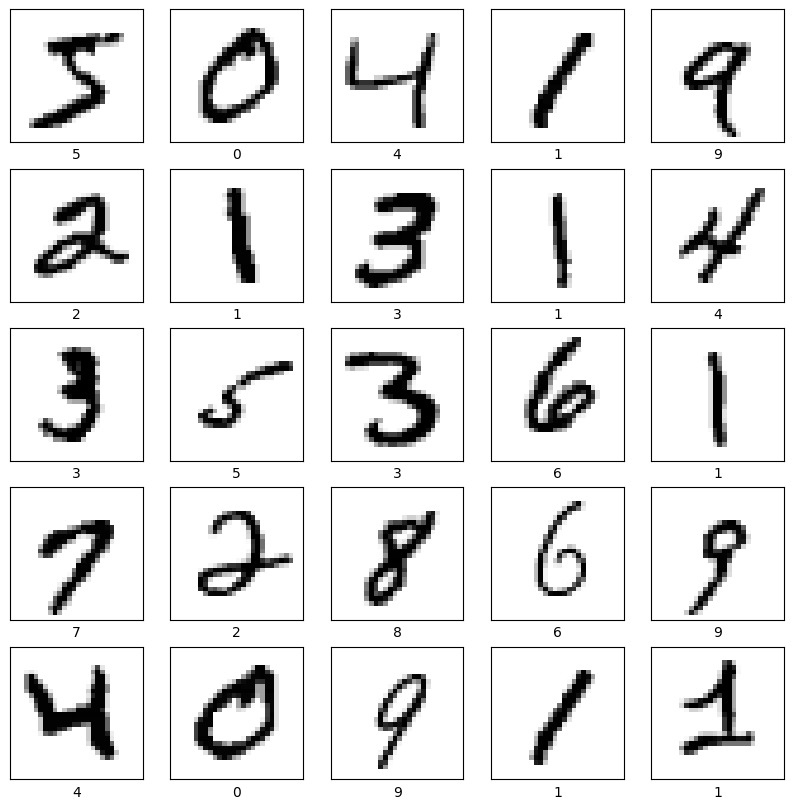

In [ ]:
# Show 25 training images
plt.figure(figsize=(10, 10))
for i in range(25):
    img = x_train_np[i]
    plt.subplot(5, 5, i+1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(int(y_train_np[i]))
plt.show()


## Build the Model

## Building a CNN in PyTorch

Now we will construct our CNN with PyTorch. As in Lecture 1, we will define a sequence of feed-forward layers, meaning that each layer is only connected to the ones that come immediately before and after it. Therefore we subclass `torch.nn.Module` and write a `forward` method that specifies how data flows through the layers.

In the cell below, construct a CNN with the following architecture:

- Convolutional layer with 32 filters, a 4 × 4 kernel, and ReLU activation  
- Max pooling layer with a 2 × 2 pool size  
- Convolutional layer with 32 filters, a 4 × 4 kernel, and ReLU activation  
- Max pooling layer with a 2 × 2 pool size  
- Fully-connected layer with 128 units and ReLU activation  
- Fully-connected layer with an output unit for each class and softmax activation  

This architecture is a mini version of the novel architecture introduced by Krizhevsky et al., which set the state-of-the-art on the ImageNet dataset and sparked the rise of CNNs.

### Tips

- Define your model as a class inheriting from `nn.Module`.  
- Use `nn.Conv2d` for convolutional layers.  
- Use `nn.MaxPool2d` for pooling layers.  
- Use `nn.Linear` for fully-connected layers.  
- Before passing into the first fully-connected layer, flatten the convolutional features
  ```

In [1]:
# We define the number of classes and the input shape from the data
num_classes = 10
input_shape = (1, 28, 28)  # (Channe,Height,Width) for PyTorch

class StudentCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # note that we are NOT building a sequential model here
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2) # can use this more than once
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1   = nn.Linear(#complete me)
        # complete me


    def forward(self, x):
        #x shape: (B,1,28,28)
        #Implement forward pass to match your layers.
        # We have to explicitly link the layers bc we
        #Example if you used the starter above:
        x = F.relu(self.conv1(x)) # we did this in two lines before
        x = self.pool(x)
        # complete me
        x = torch.flatten(x, 1)
        # complete me
        return x

model = StudentCNN().to(device)
print(model)


SyntaxError: '(' was never closed (ipython-input-201935072.py, line 12)

In [ ]:

# Optimizer, loss: like before
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader):
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()

        #make predictions
        # complete me

        # compute loss
        # complete me

        # back prop
        # complete me

        # update weights
        # complete me

        total_loss += loss.item() * xb.size(0)
        total_correct += (logits.argmax(1) == yb).sum().item()
        total += xb.size(0)
    return total_loss/total, total_correct/total # return loss and accuracy

def evaluate(model, loader):
    model.eval()
    #print(classification_report(y_true, predictions, target_names=class_names))
    total_loss, total_correct, total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            total_correct += (logits.argmax(1) == yb).sum().item()
            total += xb.size(0)
    return total_loss/total, total_correct/total

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

epochs = 5
# training loop
for epoch in range(1, epochs+1):
    tr_loss, tr_acc = train_epoch(model, train_loader)
    va_loss, va_acc = evaluate(model, test_loader)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")


Epoch 01 | train loss 0.1459 acc 0.9547 | val loss 0.0542 acc 0.9808
Epoch 02 | train loss 0.0434 acc 0.9867 | val loss 0.0334 acc 0.9891
Epoch 03 | train loss 0.0307 acc 0.9906 | val loss 0.0285 acc 0.9902
Epoch 04 | train loss 0.0227 acc 0.9928 | val loss 0.0331 acc 0.9899


In [ ]:
loss_end, accuracy = evaluate(model,test_loader)
print(accuracy)

In [ ]:
plot_learning_curve(history)

# make predictions
y_pred = # complete me


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)






# Classifying AT-TPC $^{46}$Ar Data

Now we are going to look at some data that comes from the $^{46}$Ar + isobuthane experiments in the AT-TPC. We will be working with 2D projections of tracks of the reaction products and will train a CNN to try to classify the particle that was produced in the reaction.

This work is based on https://arxiv.org/abs/1810.10350

### Data exploration and preprocessing

First we load in the AT-TPC data. We will be working with two datasets: one contains real experimental data from the AT-TPC and the other contains simulated events that were created with [`pytpc`](https://github.com/ATTPC/pytpc).

Real: (2689, 128, 128) float32 (2689,)
Sim : (50000, 128, 128) float32 (50000,)


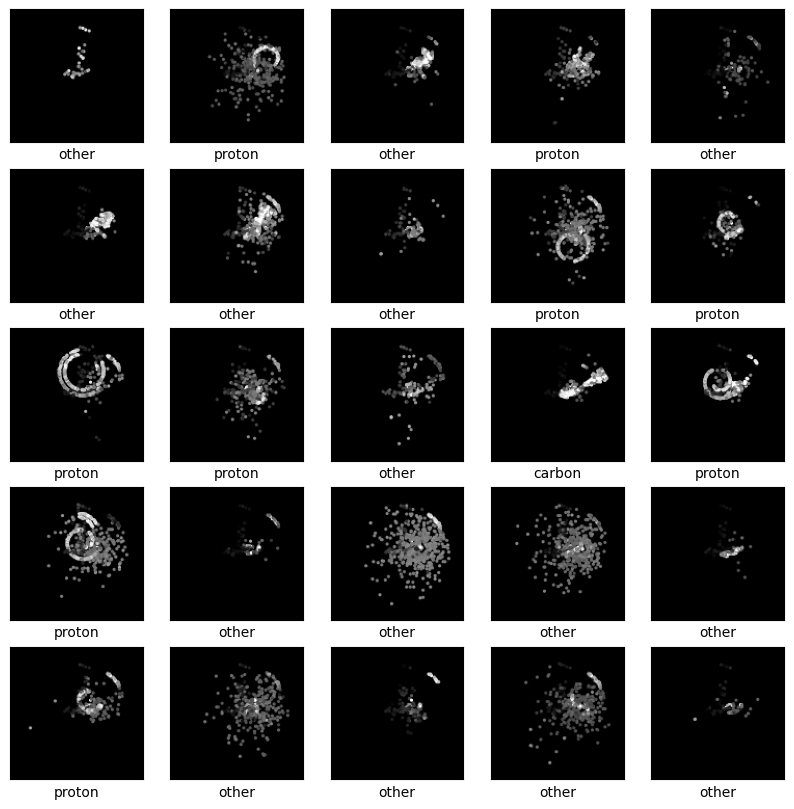

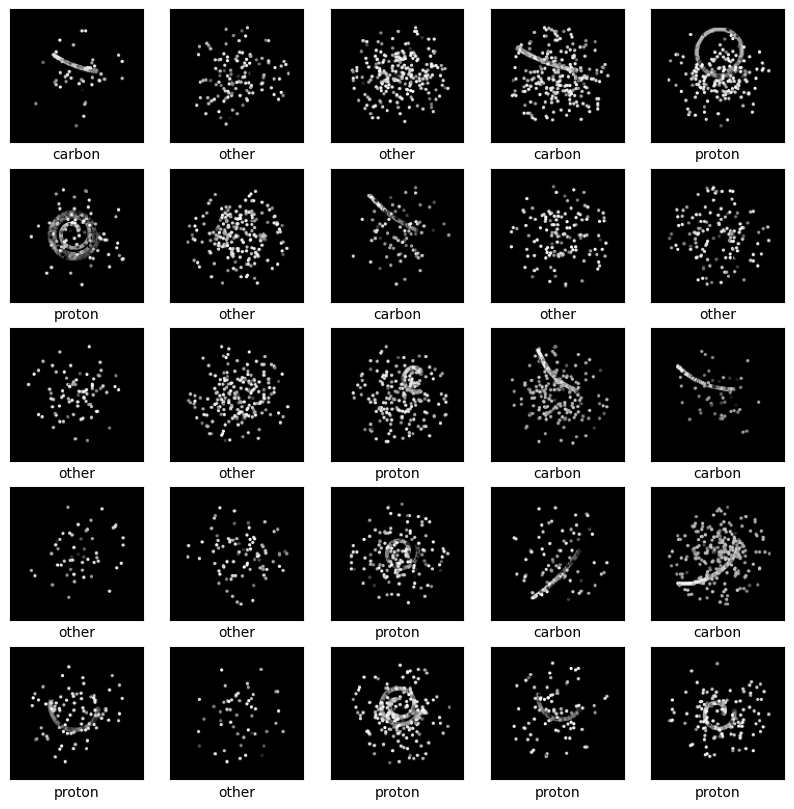

In [10]:
(real_features, real_targets), (sim_features, sim_targets) = load_attpc_data()
print("Real:", real_features.shape, real_features.dtype, real_targets.shape)
print("Sim :", sim_features.shape, sim_features.dtype, sim_targets.shape)

# Visualize 25 real examples
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(real_features[i], cmap=plt.cm.binary)
    plt.xlabel(get_attpc_class(real_targets[i]))
plt.show()

# Visualize 25 simulated examples
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(sim_features[i], cmap=plt.cm.binary)
    plt.xlabel(get_attpc_class(sim_targets[i]))
plt.show()

In both datasets, each image is 128 x 128 and has pixel values in the range 0 - 255. There 50,000 simulated events, and 2,689 real events have been hand-labeled. Notice that this data has not yet been partitioned into training, validation, and testing sets.


Again, we need to preprocess the data. **In the cell below, normalize the data and add a channel dimension, as we did with the MNIST data.** Create a train/val/test set.

In [ ]:
# complete me

### Build the model

In this example, we are going to do things a little differently. For the MNIST data, we constructed our own CNN and trained it from scratch. That worked really well for us because it was a small network, small dataset, and relatively easy problem. In practice, designing and training high-performing CNNs from scratch is time consuming and requires large-scale resources. So it is often best not to try to do this yourself. Luckily, companies like Google have already done the heavy lifting for us. TensorFlow provides access to several high-quality networks that have already been trained on datasets with millions of diverse images (such as [ImageNet](http://www.image-net.org)) as general computer-vision models. These complex networks have been trained to identify objects from up 1000 categories. This may not seem immediately useful, but it turns out that training these models on such a large scale forces the networks to learn to extract features are are broadly applicable to many computer vision tasks.

So rather than being a hero and training a CNN from scratch, we can instead use the pretrainined convolutional layers from one of these published models and add our own fully-connected classification layers on top. We keep the weights of the convolutional layers frozen, since we know they are already very good at feature extraction, and only update the weights of the top layers, which do the actual classification. This is much faster than training a CNN from scratch, and it can also result in better performance.

First, we are going to load in one of these pretrained models. In this example, we are going to use the [VGG16](https://arxiv.org/abs/1409.1556) architecture for image recognition (depicted below).

![VGG16 Architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

Before we actually load the model, there is one final caveat. The VGG network requires that its input images have three channels. Our images currently only have one, so we will add two more channels with the same values as the first. The new image dimensions should be 128 x 128 x 3.

### Train the model

We are almost ready to train, but first we need to define our learning problem. With the MNIST data, you were provided with training and testing sets that came from the same data distribution. In practice, though, we are not always afforded this luxury. Aquiring large amounts of high-quality labeled data is often very challenging. In fact, the whole reason we want to train a classifier for the AT-TPC is so that humans don't need to hand-label the data! So while we could train the network on the real data, we are instead going to try *transfer learning*. This is when we train a model on one data distribution and try to transfer what it learns to a different distribution. In our case, we will train on the simulated data and save the real data for testing. Labeled simulated data is usually readily available in large quantities, so we want to try to use that to our advantage.


Note that training this model will take longer than with the MNIST data. There are a couple of reasons for this. Obviously the network is much larger, and even though we are only training the top layers, there is still an expensive forward pass through the entire network. Also, our AT-TPC images are larger than the MNIST data. This should give you an idea for how these problems scale and why we like to start from networks that have already been trained on millions of images (rather than doing it ourselves).

We are going to start by using only 5,000 training examples so that the training time is managable at first (should be about 20 seconds per epoch on a GPU).

In [12]:
# Transfer learning with a pretrained VGG (requires 3 channels).
# We'll upsample/stack grayscale to 3 channels and 224x224.
from torchvision.transforms import Resize
class ATTPCDataset(Dataset):
    def __init__(self, features, targets):
        self.X = features.astype(np.float32)
        self.y = targets.astype(np.int64)
        self.resize = Resize((224,224)) # resize data to match VGG architecture
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        img = torch.from_numpy(self.X[idx]).unsqueeze(0)  # (1,H,W)
        # Normalize to [0,1]
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-6)
        img = self.resize(img)  # (1,224,224)
        img = img.repeat(3,1,1)  # (3,224,224)
        return img, int(self.y[idx])

subset = 5000
print(subset)
train_vgg = ATTPCDataset(sim_features[:subset], sim_targets[:subset])
val_split = 0.2
n_val = int(len(train_vgg)*val_split)
n_train = len(train_vgg) - n_val
train_vgg, val_vgg = torch.utils.data.random_split(train_vgg, [n_train, n_val], generator=torch.Generator().manual_seed(42))
train_vgg_loader = DataLoader(train_vgg, batch_size=16, shuffle=True)
val_vgg_loader   = DataLoader(val_vgg, batch_size=16, shuffle=False)




5000


NameError: name 'train_epoch_generic' is not defined

In [ ]:
num_classes_attpc = len(np.unique(sim_targets))

# load pretrained weights
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# replace last layer
vgg.classifier[-1] = nn.Linear(vgg.classifier[-1].in_features, num_classes_attpc)
# Adam is an effictive SGD optimizer
opt_vgg = optim.Adam(vgg.parameters(), lr=1e-4)
# applies softmax activation to last layer automatically
crit_vgg = nn.CrossEntropyLoss()


# Freeze all layers
for param in vgg.parameters():
    param.requires_grad = False

# Unfreeze only the last classifier layer
for param in vgg.classifier[-1].parameters():
    param.requires_grad = True


# make sure the trainable part of model is what I expect
# We count and print trainable parameters
trainable_params = [name for name, p in vgg.named_parameters() if p.requires_grad]

print("Trainable layers:")
for name in trainable_params:
    print(name)

total_params = sum(p.numel() for p in vgg.parameters())
trainable_params_count = sum(p.numel() for p in vgg.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params_count:,}")
print(f"Frozen parameters: {total_params - trainable_params_count:,}")

vgg = vgg.to(device)

def train_epoch_vgg(vgg, train_vgg_loader, opt_vgg, crit_vgg):
  # complete me

def eval_vgg(vgg, train_vgg_loader, opt_vgg, crit_vgg):
  # complete me


# training loop
for epoch in range(3):
    tr_loss, tr_acc = train_epoch_vgg(vgg, train_vgg_loader, opt_vgg, crit_vgg)
    va_loss, va_acc = eval_vgg(vgg, val_vgg_loader, crit_vgg)
    print(f"[VGG] Epoch {epoch+1}: train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")